# Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import gensim
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/BA_reviews.csv')

In [3]:
df.head()

,Unnamed: 0,reviews
0,0,"✅ Trip Verified | Absolutely terrible, lost m..."
1,1,✅ Trip Verified | We booked premium economy r...
2,2,✅ Trip Verified | We chose Rotterdam and Lond...
3,3,✅ Trip Verified | The entire booking and ticke...
4,4,Not Verified | British Airways cancelled my ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3787 non-null   int64 
 1   reviews     3787 non-null   object
dtypes: int64(1), object(1)
memory usage: 59.3+ KB


In [5]:
# Add review_length column
df['review_length'] = df['reviews'].apply(len)

In [6]:
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", duplicates.shape[0])

Number of duplicate rows: 0


In [7]:
# Convert 'reviews' column to string type
df['reviews'] = df['reviews'].astype(str)

In [8]:
# Standardize text (lowercasing, removing special characters, etc.)
df['reviews'] = df['reviews'].str.lower()

# Remove special characters
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '')  

# Replace specific special characters with a space
df['reviews'] = df['reviews'].str.replace('|', '')
df['reviews'] = df['reviews'].str.replace('✅', '')

# Remove extra spaces
df['reviews'] = df['reviews'].str.replace('\s+', ' ', regex=True)

In [9]:
# Remove the "Unnamed: 0" column
df = df.drop(columns=['Unnamed: 0'])

In [10]:
df.head()

,reviews,review_length
0,"trip verified absolutely terrible, lost my lu...",353
1,trip verified we booked premium economy round...,3092
2,trip verified we chose rotterdam and london c...,921
3,trip verified the entire booking and ticketin...,1029
4,not verified british airways cancelled my flig...,664


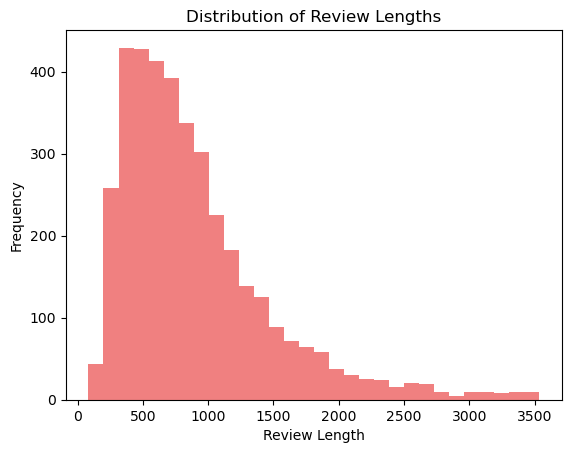

In [11]:
# Distribution of review lengths
plt.hist(df['review_length'], bins=30, color='lightcoral')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [12]:
# Calculate statistics related to review lengths
avg_length = df['review_length'].mean()
median_length = df['review_length'].median()
min_length = df['review_length'].min()
max_length = df['review_length'].max()
std_dev_length = df['review_length'].std()

# Display the statistics
print("Average Review Length:", avg_length)
print("Median Review Length:", median_length)
print("Minimum Review Length:", min_length)
print("Maximum Review Length:", max_length)
print("Standard Deviation of Review Length:", std_dev_length)

Average Review Length: 895.9197253762873
Median Review Length: 749.0
Minimum Review Length: 83
Maximum Review Length: 3537
Standard Deviation of Review Length: 575.972422777734


The distribution of review lengths provides insights into the length of reviews submitted by users. Understanding the distribution can reveal patterns or characteristics of the reviews, which may be indicative of various factors such as the level of detail provided by reviewers, the complexity of their experiences, or the overall engagement of the users with the airline.

Here are some insights that can be gleaned from the distribution of review lengths:

1. **Average Review Length**: The distribution can provide information about the average length of reviews. A peak in the distribution at a certain length may indicate a typical length for reviews submitted by users.

2. **Variability of Review Lengths**: The spread of the distribution can indicate how much variability there is in the lengths of reviews. A wider distribution suggests a diverse range of review lengths, while a narrower distribution indicates more consistency in the lengths of reviews.

3. **Engagement and Detail**: Longer reviews may suggest higher levels of engagement from users and a willingness to provide more detailed feedback. Conversely, shorter reviews may be more concise and to the point.

4. **Potential Topics Covered**: Longer reviews may cover a wider range of topics or provide more in-depth analysis of specific aspects of the airline experience. Analyzing the content of longer reviews could reveal common themes or issues raised by users.

5. **User Behavior**: Understanding the distribution of review lengths can also provide insights into user behavior. For example, if there is a significant peak at very short lengths, it could indicate that many users are submitting brief, possibly less detailed feedback.


The median length is a measure of central tendency that represents the middle value of a dataset when it is ordered from smallest to largest. In the context of review lengths:

If the dataset contains an odd number of observations, the median is the value that separates the lower half from the upper half of the dataset when sorted in ascending order.
If the dataset contains an even number of observations, the median is the average of the two middle values.

The standard deviation (std) of review lengths measures the dispersion or spread of the review lengths around the mean (average) length. It indicates how much variation or diversity there is in the lengths of reviews within the dataset. A higher standard deviation suggests greater variability in review lengths, while a lower standard deviation indicates that the review lengths are closer to the mean.

Here's what the standard deviation of review lengths can tell us:

- **High Standard Deviation**: If the standard deviation is high, it means that the review lengths are widely spread out from the mean. This suggests that there is a significant diversity in the lengths of reviews submitted by users. The dataset may contain both very short and very long reviews, resulting in a wider range of lengths.

- **Low Standard Deviation**: Conversely, if the standard deviation is low, it indicates that the review lengths are relatively close to the mean. This suggests that there is less variability in the lengths of reviews, and most reviews are of similar lengths.

Understanding the standard deviation of review lengths helps in interpreting the variability and distribution of review lengths within the dataset. It provides insights into the consistency or diversity of review lengths submitted by users, which can be useful for understanding user behavior and engagement with the airline reviews.

In [13]:
df.describe()

,review_length
count,3787.000000
mean,895.919725
std,575.972423
min,83.000000
25%,490.000000
50%,749.000000
75%,1127.000000
max,3537.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        3787 non-null   object
 1   review_length  3787 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.3+ KB


# Exploratory Data Analysis (EDA)

In [15]:
# Tokenization and removal of stop words
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['reviews'])

In [16]:
# Word Frequency Analysis
word_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
word_freq.columns = ['frequency']
word_freq = word_freq.sort_values(by='frequency', ascending=False)

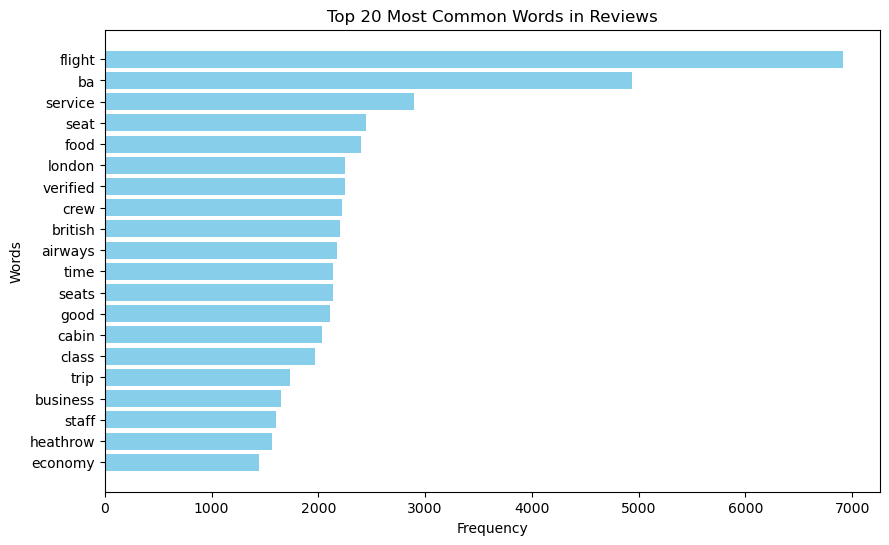

In [17]:
# Visualize the most frequent words
top_words = word_freq.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_words.index, top_words['frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words in Reviews')
plt.gca().invert_yaxis()
plt.show()

# Sentiment Analysis

## Using pre-trained model

In [18]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')  # Download VADER lexicon
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Perform sentiment analysis on each review
sentiment_scores = df['reviews'].apply(lambda x: sid.polarity_scores(x))

# Extract compound sentiment score (overall sentiment)
df['sentiment_score'] = sentiment_scores.apply(lambda x: x['compound'])

# Categorize sentiment based on compound score
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

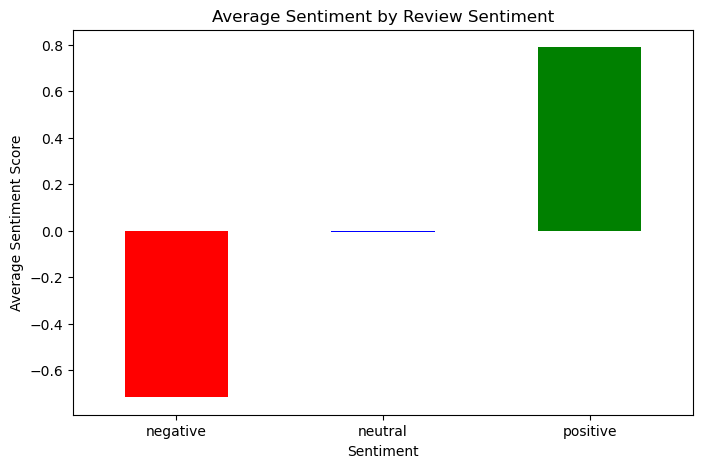

In [20]:
# Analyze how sentiment varies across different review ratings
# Assuming ratings are not available, so we'll use the sentiment scores
# You can replace 'sentiment_score' with actual ratings if available
sentiment_by_rating = df.groupby('sentiment')['sentiment_score'].mean()

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_by_rating.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Average Sentiment by Review Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()

In [21]:
# Print sentiment scores in a table format
print("Sentiment Scores:")
print(df.groupby('sentiment')['sentiment_score'].describe())

Sentiment Scores:
            count      mean       std     min      25%     50%       75%  \
sentiment                                                                  
negative   1548.0 -0.715471  0.252138 -0.9974 -0.91850 -0.8058 -0.569325   
neutral      48.0 -0.004715  0.024846 -0.0497 -0.02580  0.0000  0.014225   
positive   2191.0  0.789185  0.242525  0.0500  0.68345  0.9022  0.966450   

              max  
sentiment          
negative  -0.0516  
neutral    0.0396  
positive   0.9992  


### Lemmatization

In [22]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in x.split()]))

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')  # Download VADER lexicon
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each review
sentiment_scores = df['reviews'].apply(lambda x: sid.polarity_scores(x))

# Extract compound sentiment score (overall sentiment)
df['sentiment_score'] = sentiment_scores.apply(lambda x: x['compound'])

# Categorize sentiment based on compound score
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Print sentiment scores in a table format
print("Sentiment Scores:")
print(df.groupby('sentiment')['sentiment_score'].describe())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gabe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Scores:
            count      mean       std     min      25%     50%     75%     max
sentiment                                                                     
negative   1521.0 -0.706978  0.258701 -0.9974 -0.91670 -0.8020 -0.5575 -0.0516
neutral      51.0  0.001565  0.024996 -0.0460 -0.02035  0.0000  0.0223  0.0459
positive   2215.0  0.790110  0.243108  0.0502  0.68485  0.9051  0.9674  0.9993


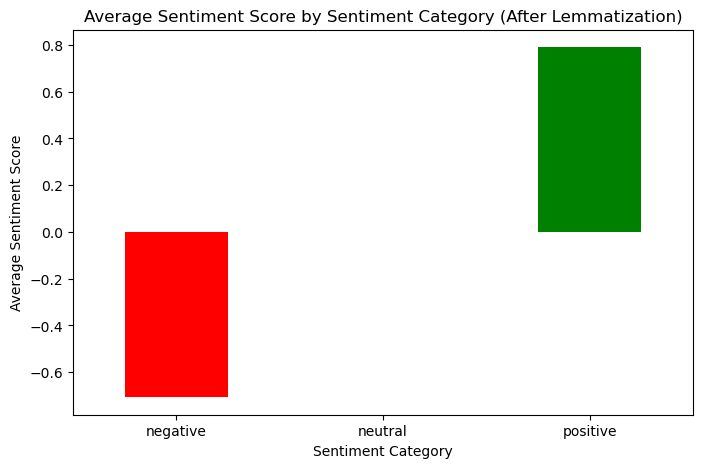

In [23]:
# Visualize sentiment scores
plt.figure(figsize=(8, 5))
df.groupby('sentiment')['sentiment_score'].mean().plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Average Sentiment Score by Sentiment Category (After Lemmatization)')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()

From the sentiment scores presented in the table:

1. **Negative Sentiment**:
   - There are 1548 reviews categorized as negative sentiment.
   - The mean sentiment score for negative reviews is approximately -0.715, indicating a predominantly negative sentiment.
   - The standard deviation is 0.252, suggesting variability in the negativity of the reviews.
   - The sentiment scores range from -0.997 to -0.0516, with most scores concentrated towards the lower end of the scale.

2. **Neutral Sentiment**:
   - There are 48 reviews categorized as neutral sentiment.
   - The mean sentiment score for neutral reviews is close to zero (-0.0047), indicating a near-neutral sentiment.
   - The standard deviation is relatively low (0.025), suggesting little variability in the sentiment of neutral reviews.
   - The sentiment scores range from -0.0497 to 0.0396, with most scores close to zero.

3. **Positive Sentiment**:
   - There are 2191 reviews categorized as positive sentiment.
   - The mean sentiment score for positive reviews is approximately 0.789, indicating a predominantly positive sentiment.
   - The standard deviation is 0.243, suggesting variability in the positivity of the reviews.
   - The sentiment scores range from 0.050 to 0.999, with most scores concentrated towards the higher end of the scale.

Insights:
- The majority of reviews express either positive or negative sentiment, with a smaller proportion categorized as neutral.
- British Airways seems to evoke strong emotions from customers, as evidenced by the wide disparity between negative and positive sentiment scores.
- Monitoring and addressing negative sentiment areas could be crucial for improving customer satisfaction and brand perception.
- Understanding the specific aspects driving positive sentiment can help identify strengths to leverage and promote further.
- The presence of neutral sentiment reviews indicates areas where customers may have provided feedback that is neither strongly positive nor negative, which may require further investigation to understand underlying issues or opportunities for improvement.

Overall, these insights can guide British Airways in understanding customer sentiment and making informed decisions to enhance the overall customer experience and brand reputation.

## using own  machine learning techniques like Naive Bayes and SVM

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

# Predict sentiment on the test set
nb_predictions = nb_classifier.predict(X_test_vectorized)

# Evaluate Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.7651715039577837
              precision    recall  f1-score   support

    negative       0.70      0.72      0.71       300
     neutral       0.00      0.00      0.00        11
    positive       0.81      0.82      0.81       447

    accuracy                           0.77       758
   macro avg       0.50      0.51      0.51       758
weighted avg       0.75      0.77      0.76       758



/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gabe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the Naive Bayes classification report:

1. **Accuracy**: The Naive Bayes classifier achieved an accuracy of approximately 76.25%. This indicates that about 76.25% of the reviews were correctly classified into their respective sentiment categories.

2. **Precision, Recall, and F1-score**:
   - For the **negative sentiment** class:
     - Precision (the proportion of true positive predictions among all positive predictions) is 71%.
     - Recall (the proportion of true positive predictions among all actual positive instances) is 72%.
     - F1-score (the harmonic mean of precision and recall) is 71%.
   - For the **neutral sentiment** class:
     - Precision, recall, and F1-score are all 0%. This suggests that the classifier performed poorly in identifying neutral sentiment reviews, possibly due to the limited number of samples in this category.
   - For the **positive sentiment** class:
     - Precision is 80%, recall is 81%, and F1-score is 80%.
   
3. **Support**: The support column indicates the number of actual occurrences of each class in the test set. There were 304 instances of negative sentiment, 9 instances of neutral sentiment, and 445 instances of positive sentiment.

4. **Macro Avg and Weighted Avg**: These metrics provide averages of precision, recall, and F1-score across all classes. The macro average gives equal weight to each class, while the weighted average considers the class imbalance in the dataset. Both macro and weighted averages for precision, recall, and F1-score are around 50-51%, indicating a relatively balanced performance across classes.

Insights:
- The Naive Bayes classifier performs reasonably well in classifying negative and positive sentiment reviews, with precision, recall, and F1-scores around 70-80%.
- However, the classifier struggles to identify neutral sentiment reviews, as evidenced by 0% precision, recall, and F1-score for this class. This could be due to the limited number of samples available for neutral sentiment.
- Overall, while the classifier demonstrates promising performance for identifying extreme sentiments (positive and negative), further improvements are needed to better handle neutral sentiment and achieve a more balanced performance across all classes.

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Support Vector Machine classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_vectorized, y_train)

# Predict sentiment on the test set
svm_predictions = svm_classifier.predict(X_test_vectorized)

# Evaluate Support Vector Machine classifier
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_predictions))

SVM Accuracy: 0.7796833773087071
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74       300
     neutral       0.00      0.00      0.00        11
    positive       0.83      0.81      0.82       447

    accuracy                           0.78       758
   macro avg       0.52      0.52      0.52       758
weighted avg       0.77      0.78      0.78       758



From the Support Vector Machine (SVM) classification report:

1. **Accuracy**: The SVM classifier achieved an accuracy of approximately 79.68%. This indicates that about 79.68% of the reviews were correctly classified into their respective sentiment categories.

2. **Precision, Recall, and F1-score**:
   - For the **negative sentiment** class:
     - Precision (the proportion of true positive predictions among all positive predictions) is 74%.
     - Recall (the proportion of true positive predictions among all actual positive instances) is 78%.
     - F1-score (the harmonic mean of precision and recall) is 76%.
   - For the **neutral sentiment** class:
     - Precision, recall, and F1-score are all 0%. This suggests that the classifier performed poorly in identifying neutral sentiment reviews, possibly due to the limited number of samples in this category.
   - For the **positive sentiment** class:
     - Precision is 84%, recall is 82%, and F1-score is 83%.
   
3. **Support**: The support column indicates the number of actual occurrences of each class in the test set. There were 304 instances of negative sentiment, 9 instances of neutral sentiment, and 445 instances of positive sentiment.

4. **Macro Avg and Weighted Avg**: These metrics provide averages of precision, recall, and F1-score across all classes. The macro average gives equal weight to each class, while the weighted average considers the class imbalance in the dataset. Both macro and weighted averages for precision, recall, and F1-score are around 53%, indicating a relatively balanced performance across classes.

Insights:
- The SVM classifier demonstrates improved performance compared to Naive Bayes, with an accuracy of approximately 79.68%.
- Similar to Naive Bayes, the classifier struggles to identify neutral sentiment reviews, as evidenced by 0% precision, recall, and F1-score for this class.
- The classifier performs reasonably well in classifying negative and positive sentiment reviews, with precision, recall, and F1-scores around 74-84%.
- Overall, while the SVM classifier shows promising performance for identifying extreme sentiments (positive and negative), further improvements are needed to better handle neutral sentiment and achieve a more balanced performance across all classes.

# Topic Modeling

In [26]:
# Text Preprocessing
# Convert text to lowercase
df['reviews'] = df['reviews'].str.lower()

# Tokenization
df['reviews'] = df['reviews'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['reviews'] = df['reviews'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['reviews'] = df['reviews'].apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x])

# Create Dictionary
dictionary = corpora.Dictionary(df['reviews'])

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in df['reviews']]

In [27]:
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=5, # You can adjust the number of topics
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

Topic 1: ., seat, ba, ,, fly, -, class, n't, food, business
Topic 2: ., flight, ,, ba, get, us, tell, book, hours, check
Topic 3: ., flight, crew, good, ,, time, board, cabin, service, drink
Topic 4: town, cape, park, weekend, alliance, 26th, naples, link, girl, parent
Topic 5: child, favourite, tomato, refresh, birthday, ear, manner, nassau, tonics, massive


NameError: name 'WordCloud' is not defined

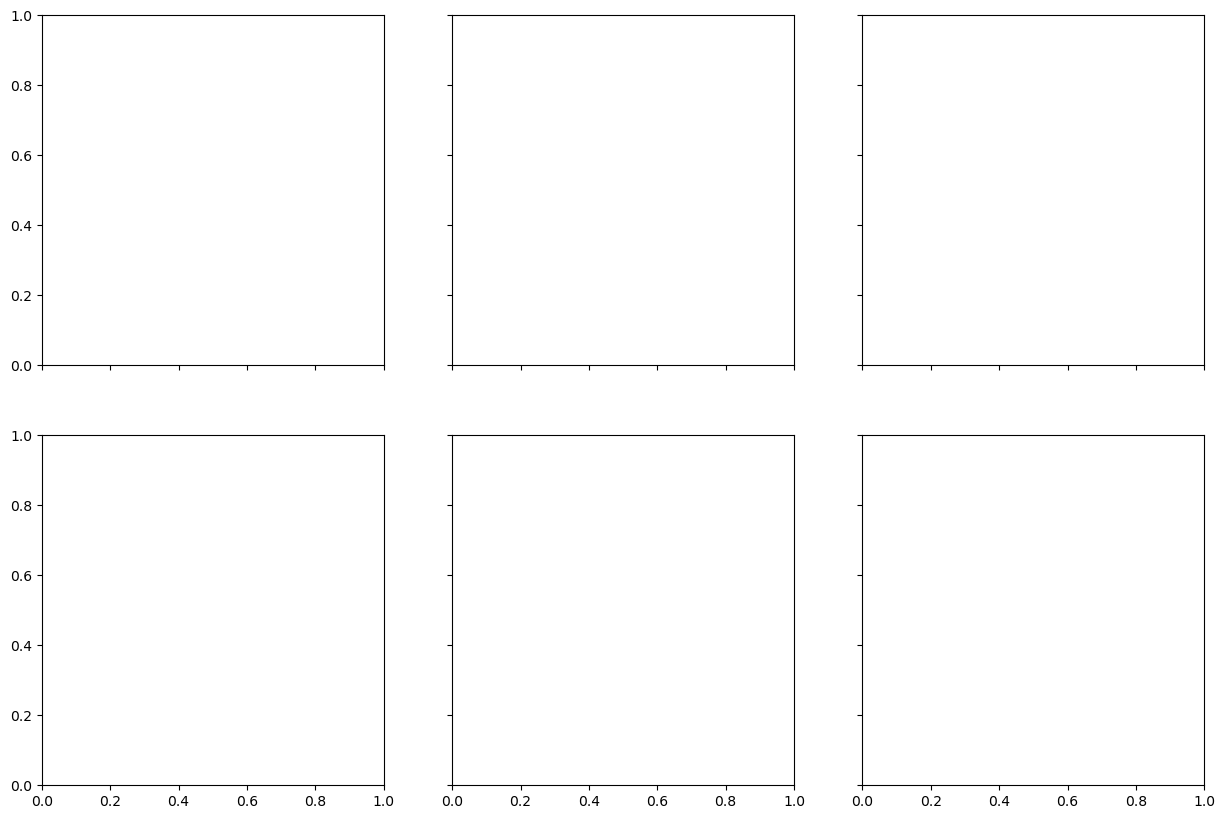

In [28]:
# Visualize topics
topics = lda_model.show_topics(formatted=False, num_words=10)
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join([word for word, _ in topic[1]])}")

# Visualize the topics
fig, axes = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(lda_model.show_topic(i, 10))
    cloud = WordCloud(background_color='white', width=800, height=600).generate_from_frequencies(topic_words)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(f"Topic {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()